# Introduction to Data Reduction using Eureka! Code

In this notebook, we will cover the installation of Eureka! as well as an example.

It contains the following steps:


```
1. Download a directory containing:
 - Calibrated Images in MJy/sr using NIRCam
 - Ancillary data files to convert from MJr/sr to Electrons
 - "Eureka control files (.ecf)" for Stage 3 and 4
 - A run_eureka.py script
2. Have a look at the fits Header
3. Plot the science image
4. Convert Units from brightness units (MJy/sr) to raw units (DN) and then to Electrons
5. Calculate the background flux
6. Subtract the background from the spectrum and sum column-wise (2D -> 1D)
7. Plot the spectrum
```

## Imports
Here are a few basic imports we'll need later on...

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

#from eureka-hackathon.S3_data_reduction import bright2flux as b2f

## Download the simulated data


This file contains simulated NIRCam grism time series data. Here, a WASP-43 b-like planet with artificial spectral features is simulated from the ERS Simulated Spectra Team. The observing mode is as follows:

- GRISMR+F322W2 pupil and filter
- RAPID readout mode
- 19 Groups per integrations
- 1287 integrations
- 1 Exposure
- 4 Output amplifiers

The data themselves are divided into “segments,” with each individual segment (seg001, seg002, etc.) containing a subset of the overall dataset. This is how flight data will be delivered. The segments are numbered in their order of observation.

For practicing on a smaller file with fewer integrations, use segment 21 (“seg021”). 
To start off, we are only downloading the last segment which is a smaller file (25MB) with fewer integrations. (The other segments are all ~225MB).

We will use Stage 2 Outputs. For NIRCam, Stage 2 consists of the flat field correction, WCS/wavelength solution, and photometric calibration (counts/sec -> MJy). Note that this is specifically for NIRCam: the steps in Stage 2 change a bit depending on the instrument. The Stage 2 outputs are rougly equivalent to a “flt” file from HST.

The files have the suffix "/*calints.fits" which contain fully calibrated images (MJy) for each individual integration. This is the one you want if you’re starting with Stage 2 and want to do your own spectral extraction.

If you want to learn more about the simulated data, click on this link: https://stsci.app.box.com/s/8r6kqh9m53jkwkff0scmed6zx42g307e/file/804595804746

All Data can be downloaded here:
https://stsci.app.box.com/s/8r6kqh9m53jkwkff0scmed6zx42g307e/folder/136379342485

## Read in the fits files

In [2]:
# Set the path where the simulated JWST NIRCam Stage 2 data is saved 
inputdir = '/home/zieba/Desktop/Data/JWST_simulated_data_may2021/hackathon/Simulated_JWST_Data/NIRCam/stage2/'

# Data file suffix
suffix = 'calints'

segment_list = []
for fname in os.listdir(inputdir):
    if fname.endswith(suffix + '.fits'):
        segment_list.append(inputdir +'/'+ fname)
        print(fname)
#segment_list = sn.sort_nicely(segment_list)
num_data_files = len(segment_list)
print(f'\nFound {num_data_files} data file(s) ending in {suffix}.fits')

jw00042001001_01101_00002-seg021_nrca5_calints.fits

Found 1 data file(s) ending in calints.fits


Note that the data themselves are divided into “segments,” with each individual segment (seg001, seg002, etc.) containing a subset of the overall dataset. This is how flight data will be delivered. The segments are numbered in their order of observation.

### Header of a fits file

In [3]:
filename = segment_list[0]
filename

'/home/zieba/Desktop/Data/JWST_simulated_data_may2021/hackathon/Simulated_JWST_Data/NIRCam/stage2//jw00042001001_01101_00002-seg021_nrca5_calints.fits'

In [4]:
# Read FITS file from JWST's NIRCam instrument

hdulist = fits.open(filename)

# Load master and science headers
mhdr    = hdulist[0].header
shdr    = hdulist['SCI',1].header

intstart    = mhdr['INTSTART']
intend      = mhdr['INTEND']

data    = hdulist['SCI',1].data
err     = hdulist['ERR',1].data
dq      = hdulist['DQ',1].data
wave    = hdulist['WAVELENGTH',1].data
v0      = hdulist['VAR_RNOISE',1].data
int_times = hdulist['INT_TIMES',1].data[intstart-1:intend]

In [5]:
mhdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2021-04-27T19:31:36.628' / UTC date file created                     
ORIGIN  = 'STScI   '           / Organization responsible for creating file     
FILENAME= 'jw00042001001_01101_00002-seg021_nrca5_calints.fits' / Name of the fi
FILETYPE= 'calibrated'         / Type of data in the file                       
CAL_VER = '1.1.1.dev62+ge2a402ac' / Calibration software version number         
CAL_VCS = 'e2a402ac'           / Calibration software version control sys number
DATAMODL= 'SlitModel'          / Type of data model                             
TELESCOP= 'JWST    '           / Telescope used to acquire the data             
                            

In [6]:
shdr

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                   64                                                  
NAXIS3  =                    7                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
SRCTYPE = 'POINT   '           / Source type used for calibration               
BUNIT   = 'MJy/sr  '           / physical units of the array values             
                                                                                
        Photometry informati

### Some Notable information from the Header

#### physical units of the array values

In [7]:
shdr['BUNIT']

'MJy/sr'

#### How many Integrations does the file contain?

In [8]:
#starting at integration number:
mhdr['INTSTART']

1281

In [9]:
#ending at integration number:
mhdr['INTEND']

1287

## Trim data to subarray region of interest

### Plot the Spectrum

In [10]:
xwindow=[100,1700]
ywindow=[5,64]

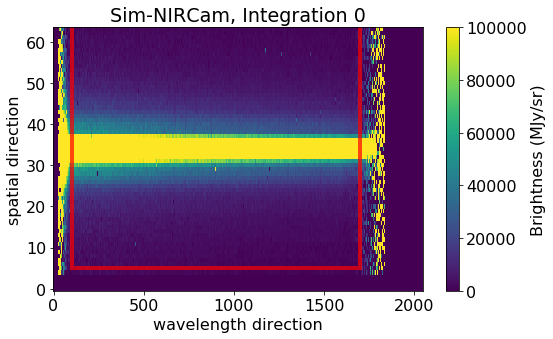

In [35]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1,1,figsize=(8,5))

rect = patches.Rectangle((xwindow[0],ywindow[0]),xwindow[1]-xwindow[0],ywindow[1]-ywindow[0], alpha=0.7, facecolor='none', edgecolor='red', lw=4)

ax.add_patch(rect)



im = ax.imshow(data[0], origin = 'lower', aspect='auto',  vmin=0, vmax=100000)
fig.colorbar(im, label='Brightness (MJy/sr)')
#plt.tight_layout()
ax.set_title('Sim-NIRCam, Integration {0}'.format(0))
ax.set_xlabel('wavelength direction')
ax.set_ylabel('spatial direction')
plt.tight_layout()
plt.savefig('xywindow.png', dpi=200)
plt.show()
plt.close()

Let's remove the edges:

In [36]:
xwindow=[100,1700]
ywindow=[5,64]

In [37]:
subdata     = data    [:,ywindow[0]:ywindow[1],xwindow[0]:xwindow[1]]
suberr      = err     [:,ywindow[0]:ywindow[1],xwindow[0]:xwindow[1]]
subwave     = wave    [  ywindow[0]:ywindow[1],xwindow[0]:xwindow[1]]
subv0       = v0      [:,ywindow[0]:ywindow[1],xwindow[0]:xwindow[1]]

In [38]:
len(subwave[0])

1600

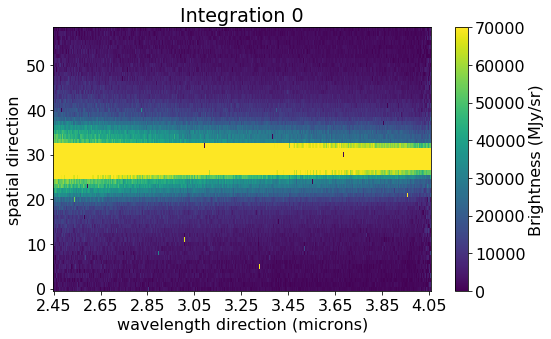

In [39]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1,1,figsize=(8,5))

im = ax.imshow(subdata[0], origin = 'lower', aspect='auto',  vmin=0, vmax=70000)
fig.colorbar(im, label='Brightness (MJy/sr)')
#plt.tight_layout()
ax.set_title('Integration {0}'.format(0))
ax.set_xlabel('wavelength direction (microns)')
ax.set_ylabel('spatial direction')

ax.set_xticks(np.arange(len(subwave[0]))[::199])
ax.set_xticklabels(['{0:.2f}'.format(i) for i in subwave[0][::199]])
plt.tight_layout()
plt.savefig('stage2.png', dpi=250)
plt.show()
plt.close()

In [57]:
ap_y2

47

In [109]:
subdata[0].shape

(59, 1600)

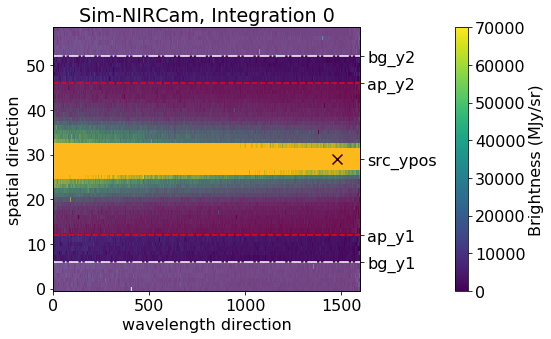

In [120]:

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

src_xpos = shdr['SRCXPOS']-xwindow[0]
src_ypos = shdr['SRCYPOS']-ywindow[0]

fig, ax = plt.subplots(1,1,figsize=(8,5))




im = ax.imshow(subdata[0], origin = 'lower', aspect='auto',  vmin=0, vmax=70000)



bg_hw    = 23
spec_hw  = 17

bg_y1   = int(src_ypos - bg_hw)
bg_y2   = int(src_ypos + bg_hw)


ap_y1   = int(src_ypos - spec_hw)
ap_y2   = int(src_ypos + spec_hw)


ax.scatter(src_xpos, src_ypos, marker='x', c='k', s=100)

ax.axhline(bg_y1, c='w', ls='-.')
ax.axhline(bg_y2, c='w', ls='-.')

ax.axhline(ap_y1, c='r', ls='--')
ax.axhline(ap_y2, c='r', ls='--')


rect1 = patches.Rectangle((0,-0.5),1600,bg_y1+0.5, alpha=0.25, facecolor='w', edgecolor='none', lw=0)
ax.add_patch(rect1)

rect2 = patches.Rectangle((0,bg_y2),1600,64, alpha=0.25, facecolor='w', edgecolor='none', lw=0)
ax.add_patch(rect2)

rect3 = patches.Rectangle((0,ap_y1),1600,ap_y2-ap_y1, alpha=0.2, facecolor='r', edgecolor='none', lw=0)
ax.add_patch(rect3)

fig.colorbar(im, label='Brightness (MJy/sr)', pad=0.2)
#plt.tight_layout()
ax.set_title('Sim-NIRCam, Integration {0}'.format(0))
ax.set_xlabel('wavelength direction')
ax.set_ylabel('spatial direction')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot([750, 750], [-0.5,58.5], c='none')
ax2.set_ylim(-0.5,58.5)


ax2.set_yticks([src_ypos, ap_y1, ap_y2, bg_y1, bg_y2])
ax2.set_yticklabels(['src_ypos', 'ap_y1', 'ap_y2', 'bg_y1', 'bg_y2' ])

ax.set_ylim(-0.5,58.5)

ax.set_xlim(0,1600)

ax2.set_xlim(0,1600)
#ax.yaxis.set_ticks_position('both')
ax.yaxis.set_label_position("left")
#ax.set_xticks(np.arange(len(subwave[0]))[::199])
#ax.set_xticklabels(['{0:.2f}'.format(i) for i in subwave[0][::199]])
plt.tight_layout()
plt.savefig('bg_hw.png', dpi=250)
plt.show()
plt.close()

## Convert Units: from brightness units (MJy/sr) to Electrons

In [45]:
import sys
sys.path.append('/home/zieba/Desktop/Projects/Open_source/Eureka')

#module_path = os.path.abspath(os.path.join('..'))
#if module_path not in sys.path:
#    sys.path.append(module_path)

from eureka.S3_data_reduction import bright2flux as b2f

#bright2dn
#dn2electrons

In [46]:
# Convert from brightness units (MJy/sr) to Electrons

photfile = '/home/zieba/Desktop/Data/JWST_simulated_data_may2021/hackathon/Simulated_JWST_Data/NIRCam/ancil/jwst_nircam_photom_0064.fits'
subdata, suberr, subv0 = b2f.bright2dn(subdata, suberr, subv0, subwave, photfile, mhdr, shdr)

gainfile = '/home/zieba/Desktop/Data/JWST_simulated_data_may2021/hackathon/Simulated_JWST_Data/NIRCam/ancil/jwst_nircam_gain_0056.fits'
subdata, suberr, subv0 = b2f.dn2electrons(subdata, suberr, subv0, gainfile, mhdr, ywindow, xwindow)

TypeError: bright2dn() takes 2 positional arguments but 7 were given

## Let's Plot the Science Image

### Determine Source position in slit using the Science Image Header

In [128]:
src_xpos = shdr['SRCXPOS']-xwindow[0]
src_ypos = shdr['SRCYPOS']-ywindow[0]

In [129]:
src_xpos

1480.0

In [130]:
src_ypos

29

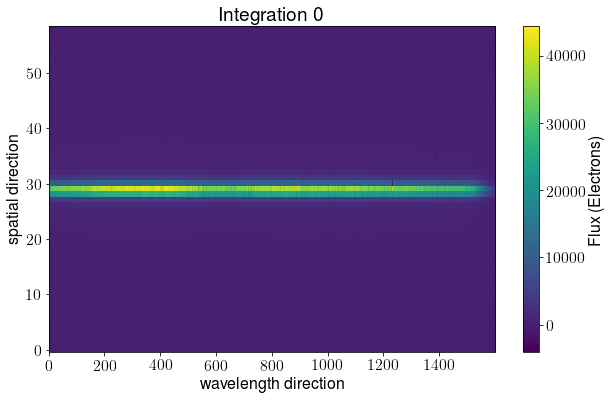

In [131]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

im = ax.imshow(subdata[0], origin = 'lower', aspect='auto')
fig.colorbar(im, label='Flux (Electrons)')
#plt.tight_layout()
ax.set_title('Integration {0}'.format(0))
ax.set_xlabel('wavelength direction')
ax.set_ylabel('spatial direction')
plt.show()
plt.close()

### Let's decide which parts we want to use for the background and for the spectrum

Let's use a +/-20 pixel area around the spectrum in the spatial direction

In [132]:
bg_hw    = 20
spec_hw  = 20

In [133]:
bg_y1   = int(src_ypos - bg_hw)
bg_y2   = int(src_ypos + bg_hw)

In [134]:
ap_y1   = int(src_ypos - spec_hw)
ap_y2   = int(src_ypos + spec_hw)

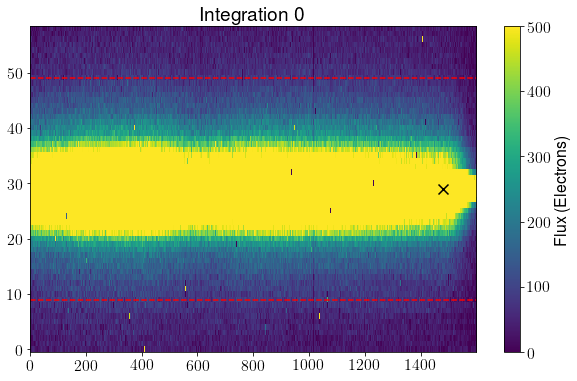

In [135]:

#print(d[1].data)
fig, ax = plt.subplots(1,1,figsize=(10,6))

im = ax.imshow(subdata[0], origin = 'lower', aspect='auto',  vmin=0, vmax=500)
ax.scatter(src_xpos, src_ypos, marker='x', c='k', s=100)
ax.axhline(bg_y1, c='r', ls='--')
ax.axhline(bg_y2, c='r', ls='--')
fig.colorbar(im, label='Flux (Electrons)')
#plt.tight_layout()
ax.set_title('Integration {0}'.format(0))
plt.show()
plt.close()

In [136]:
submask = np.zeros(subdata.shape)

submask[:,  :bg_y1] = 1
submask[:,bg_y2:  ] = 1

### Calculate background in every column

In [137]:
bg = np.array([[np.median(subdata[0, :, i][np.where(submask[0, :, i])])]*59 for i in range(1600)]).T

### Subtract background

In [144]:
data_bgcorr = subdata[0] - bg

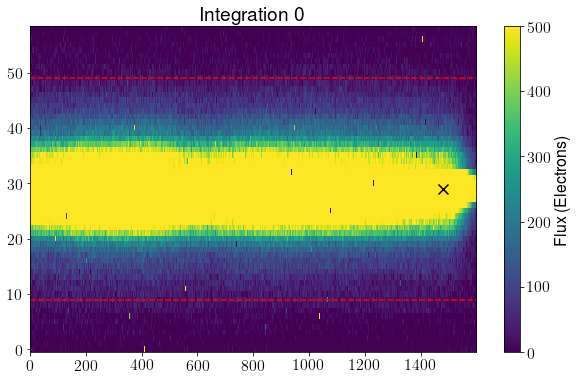

In [145]:
#print(d[1].data)
fig, ax = plt.subplots(1,1,figsize=(10,6))

im = ax.imshow(data_bgcorr, origin = 'lower', aspect='auto',  vmin=0, vmax=500)
#im = ax.imshow(bgdata2[0], origin = 'lower', aspect='auto',  vmin=0, vmax=10000)
ax.scatter(src_xpos, src_ypos, marker='x', c='k', s=100)
ax.axhline(bg_y1, c='r', ls='--')
ax.axhline(bg_y2, c='r', ls='--')
fig.colorbar(im, label='Flux (Electrons)')
#plt.tight_layout()
ax.set_title('Integration {0}'.format(0))
plt.show()
plt.close()

### Add up data in the earlier defined spectrum box

In [146]:
apdata      = data_bgcorr[ap_y1:ap_y2]
stdspec     = np.sum(apdata, axis=0)

## Plot spectrum

In [142]:
wvl = wave[0][xwindow[0]:xwindow[1]]

Text(0, 0.5, 'Flux (Electrons)')

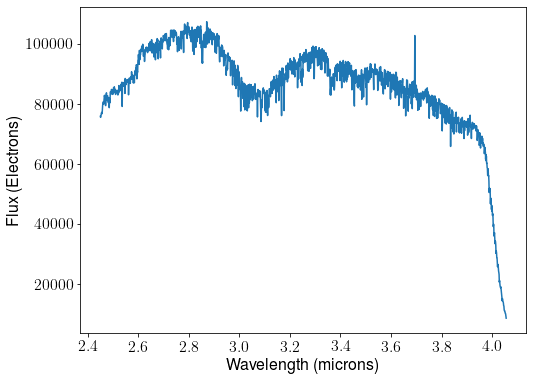

In [143]:
fig, ax=plt.subplots(figsize=(8,6))

ax.plot(wvl, stdspec)
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel('Flux (Electrons)')